
# Optical Flow: Predicting movement with the RAFT model

Optical flow is the task of predicting movement between two images, usually two
consecutive frames of a video. Optical flow models take two images as input, and
predict a flow: the flow indicates the displacement of every single pixel in the
first image, and maps it to its corresponding pixel in the second image. Flows
are (2, H, W)-dimensional tensors, where the first axis corresponds to the
predicted horizontal and vertical displacements.

The following example illustrates how torchvision can be used to predict flows
using our implementation of the RAFT model. We will also see how to convert the
predicted flows to RGB images for visualization.


In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
from raft_functions import *


plt.rcParams["savefig.bbox"] = "tight"


def plot(imgs, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0])
    _, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            img = F.to_pil_image(img.to("cpu"))
            ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    plt.tight_layout()

c:\Users\Misha\anaconda3\envs\fyp\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Reading Videos Using Torchvision
We will first read a video using :func:`~torchvision.io.read_video`.
Alternatively one can use the new :class:`~torchvision.io.VideoReader` API (if
torchvision is built from source).
The video we will use here is free of use from [pexels.com](https://www.pexels.com/video/a-man-playing-a-game-of-basketball-5192157/),
credits go to [Pavel Danilyuk](https://www.pexels.com/@pavel-danilyuk).



:func:`~torchvision.io.read_video` returns the video frames, audio frames and
the metadata associated with the video. In our case, we only need the video
frames.

Here we will just make 2 predictions between 2 pre-selected pairs of frames,
namely frames (100, 101) and (150, 151). Each of these pairs corresponds to a
single model input.



In [180]:
from torchvision.io import read_video
from torch import from_numpy
import skimage
def load_image_batches(path, step = 10, smooth = 5):
    # path = "C:/Users/Misha/OneDrive - University of Sussex/FYP/Participants/Participant_12/Processed_data/Video/Subject_12_03.mp4"

    frames, _, _ = read_video(str(path), output_format="TCHW") # returns video frames, audio frames, metadata for the video and audio
    # print(frames.shape)
    images1 = []
    images2 = []
    img = np.array([np.moveaxis(frames[a].numpy()[:,:,:], 0, -1) for a in range(len(frames))])
    # print(img.shape)
    # print(sm.structural_similarity(img[0, 200:500, 600:900, 0], img[1, 200:500, 600:900, 0]))
    # len(frames)-2
    for i in range(0, len(frames)-2, step):
        img1 = img[i, 100:600, 500:1000, :]
        img2 = img[i+1, 100:600, 500:1000, :]
        if (sm.structural_similarity(img1[:,:,0], img2[:,:,0]) < 0.95):
            # print(sm.structural_similarity(img[i, 200:500, 600:900, 0], img[i+1, 200:500, 600:900, 0]))
            # plt.imshow(img1, cmap = 'gray'), plt.show()
            # plt.imshow(img[i+1, 200:500, 600:900, 0], cmap = 'gray'), plt.show()
            # blur = cv2.bilateralFilter(img1, smooth, 160, 160)
            # blurred = np.moveaxis(blur, -1, 0)
            # blurred2 = np.moveaxis(cv2.bilateralFilter(img2,smooth,160,160), -1, 0)
            # print(img1.dtype)
            new_shape = (img1.shape[0] , img1.shape[1] , img1.shape[2])
            blurred1 = skimage.transform.resize(image=img1, output_shape=new_shape).astype(np.float32)
            blurred2 = skimage.transform.resize(image=img2, output_shape=new_shape).astype(np.float32)
            # print(blurred1.shape)

            blurred_1 = np.moveaxis(cv2.bilateralFilter(blurred1,smooth,160,160), -1, 0)
            blurred_2 = np.moveaxis(cv2.bilateralFilter(blurred2,smooth,160,160), -1, 0)

            # print(blurred.shape)
            # plt.imshow(blurred, cmap= 'gray'), plt.show()
            images1.append(torch.from_numpy(blurred_1))
            images2.append(torch.from_numpy(blurred_2))
            # images1.append(frames[i, :, 200:500, 600:900])
            # images2.append(frames[i+1, :, 200:500, 600:900])

    img1_batch = torch.stack(images1) # making predictions between 2 pairs of frames 53 and 83, and 84 and 130
    img2_batch = torch.stack(images2)

    return img1_batch, img2_batch

In [183]:
from torchvision.io import read_video
from torch import from_numpy
import skimage
def load_image_batches_all(paths, step = 10, smooth = 5):
    # path = "C:/Users/Misha/OneDrive - University of Sussex/FYP/Participants/Participant_12/Processed_data/Video/Subject_12_03.mp4"
    images1 = []
    images2 = []

    for num, path in enumerate(paths):
        print(num)
        print(path)

    frames, _, _ = read_video(str(path), output_format="TCHW") # returns video frames, audio frames, metadata for the video and audio
    # print(frames.shape)

    img = np.array([np.moveaxis(frames[a].numpy()[:,:,:], 0, -1) for a in range(len(frames))])

    for i in range(0, len(frames)-2, step):
        img1 = img[i, 100:600, 500:1000, :]
        img2 = img[i+1, 100:600, 500:1000, :]
        if (sm.structural_similarity(img1[:,:,0], img2[:,:,0]) < 0.95):

            new_shape = (img1.shape[0] , img1.shape[1] , img1.shape[2])
            blurred1 = skimage.transform.resize(image=img1, output_shape=new_shape).astype(np.float32)
            blurred2 = skimage.transform.resize(image=img2, output_shape=new_shape).astype(np.float32)

            blurred_1 = np.moveaxis(cv2.bilateralFilter(blurred1,smooth,160,160), -1, 0)
            blurred_2 = np.moveaxis(cv2.bilateralFilter(blurred2,smooth,160,160), -1, 0)

            images1.append(torch.from_numpy(blurred_1))
            images2.append(torch.from_numpy(blurred_2))

    img1_batch = torch.stack(images1) # making predictions between 2 pairs of frames 53 and 83, and 84 and 130
    img2_batch = torch.stack(images2)

    return img1_batch, img2_batch

In [176]:
# Check if the file path exists for the initial video
import os
# home
# path = "C:/Users/Misha/OneDrive - University of Sussex/FYP/Participants/notext/Participant_12_no_labels/Processed_data/Video/Subject_12_03.mp4"

#SEMI WORKING
# path = "C:/Users/Misha/OneDrive - University of Sussex/FYP/Participants/VIDEOS_ALL/segment_A Taal)dcmekf.mp4"
path = "C:/Users/Misha/OneDrive - University of Sussex/FYP/Participants/VIDEOS_ALL/segment_ad Laat #)ebsoht.mp4"

# path = "/Users/men22/OneDrive - University of Sussex/FYP/Participants/Participant_09/Processed_data/Video/Subject_09_05.mp4"
# path = "C:/Users/men22/OneDrive - University of Sussex/FYP/Participants/Participant_6/Processed_data/Video/Subject_06_05.mp4"
print("file exists?", os.path.exists(path))

file exists? True


In [174]:
import os
# home
# path = "/Users/men22/OneDrive - University of Sussex/FYP/Participants/Participant_09/Processed_data/Video/Subject_09_05.mp4"
path = "C:/Users/men22/OneDrive - University of Sussex/FYP/Participants/VIDEOS_ALL/segment_Ynganugqnppn.mp4"
print("file exists?", os.path.exists(path))

file exists? False


In [185]:
img1_batch, img2_batch = load_image_batches(path, 1, 24)

c:\Users\Misha\anaconda3\envs\fyp\lib\site-packages\torchvision\io\video.py:162: UserWarning: The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.
  warnings.warn("The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.")


[]


RuntimeError: stack expects a non-empty TensorList

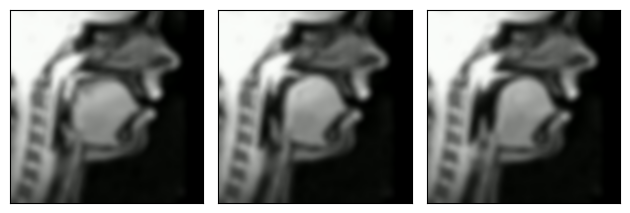

In [134]:
plot(img1_batch[0:4])

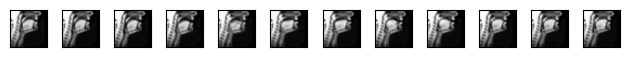

In [145]:
plot(img1_batch)

In [ ]:
# path = "C:/Users/Misha/OneDrive - University of Sussex/FYP/Participants/Participant_12/Processed_data/Video/Subject_12_01.mp4"
# path = "/Users/men22/OneDrive-UniversityofSussex/FYP/Participants/Participant_12/Processed_data/Video/Subject_12_01.mp4"
from torchvision.io import read_video
import av
frames, _, _ = read_video(str(path), output_format="TCHW") # returns video frames, audio frames, metadata for the video and audio

img1_batch = torch.stack([frames[53, :, 100:600, 500:1000], frames[84, :, 100:600, 500:1000]]) # making predictions between 2 pairs of frames 53 and 83, and 84 and 130
img2_batch = torch.stack([frames[105, :, 100:600, 500:1000], frames[130, :, 100:600, 500:1000]])
# img1_batch = frames[53, :, 100:600, 500:1000]
# img2_batch = frames[84, :, 100:600, 500:1000]
# 150:500, 600:900 smaller concentrated image
# 100:600, 500:1000 slightly bigger
# plot(img1_batch)

In [120]:
img1_batch.shape

torch.Size([7, 3, 500, 500])

In [ ]:
img2_batch.shape

In [116]:

from torchvision.models.optical_flow import Raft_Large_Weights

from torchvision.models.optical_flow import raft_large

def preprocess(img1_batch, img2_batch, transf = 'large', s = 352):
    if transf == 'large':
        weights = Raft_Large_Weights.DEFAULT
    else: 
        weights = Raft_Small_Weights.DEFAULT
    transforms = weights.transforms()
    # img1_batch = F.resize(img1_batch, size=[520, 960], antialias=False)
    # img2_batch = F.resize(img2_batch, size=[520, 960], antialias=False)
    img1_batch = F.resize(img1_batch, size=[s, s], antialias=False) # resize frames to ensure they are divisable by 8 
    img2_batch = F.resize(img2_batch, size=[s, s], antialias=False)
    return transforms(img1_batch, img2_batch)

def raft(img1_batch, img2_batch, raft_ = 'large', device = 'cpu'):
    # set the weights
    if raft_ == 'large':
        weights = Raft_Large_Weights.DEFAULT
    else: 
        weights = Raft_Small_Weights.DEFAULT
    # prepare the images for the model
    # img1_batch, img2_batch = preprocess(img1_batch, img2_batch, transf = raft_, s = s)
    # create model
    model = raft_large(weights, progress=False).to(device)
    model = model.eval()

    # get list of predictions
    list_of_flows = model(img1_batch.to(device), img2_batch.to(device))
    # get the last one - most accurate
    predicted_flow = list_of_flows[-1]

    return predicted_flow


In [8]:
from raft_functions import *

In [146]:
# from raft_functions import raft
size = 336
img1__batch, img2__batch = preprocess(img1_batch, img2_batch, s = size)
predicted_flow1 = raft(img1__batch, img2__batch)

In [ ]:
def convert_flow(predicted_flows):
    flows_tchw = [predicted_flows[a].detach().numpy()[:,:,:] for a in range(predicted_flows.shape[0])] # make it back to numpy arrays for all N predicted flows
    flows = np.moveaxis(flows_tchw, 1, -1) # change the dimmensions from TCHW to THWC
    return flows

In [ ]:
def convert_images(img_batch):
    # print(img_batch.shape)
    img2_batch = [(img2 + 1) / 2 for img2 in img_batch] # upsampling the image back to original
    # print(len(img2_batch))
    img2 = np.array([np.moveaxis(img2_batch[a].numpy()[:,:,:], 0, -1) for a in range(len(img_batch))])
    return img2

In [41]:
images = convert_images(img1__batch)
# blurred  = cv2.bilateralFilter(images[0],9,75,75)
# blurred.shape
images.shape

(7, 352, 352, 3)

(352, 352, 3)
(88, 88, 3)


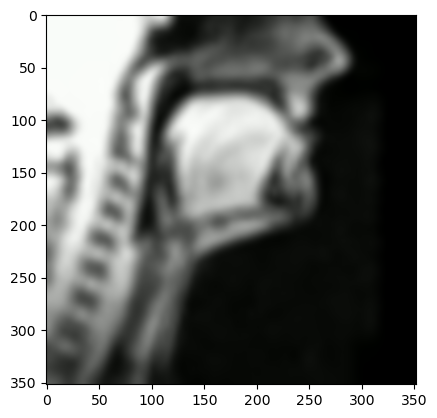

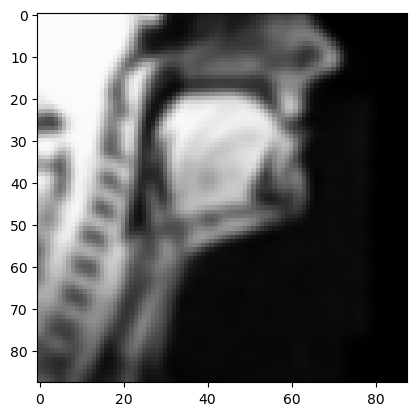

(<matplotlib.image.AxesImage at 0x2688535a970>, None)

In [42]:
new_shape = (images[0].shape[0] //4, images[0].shape[1] // 4, images[0].shape[2])
small = skimage.transform.resize(image=images[0], output_shape=new_shape)
print(images[0].shape)
print(small.shape)
plt.imshow(images[0]), plt.show()
plt.imshow(small), plt.show()

In [ ]:
blur = cv2.bilateralFilter(small,5,160,160)
plt.imshow(blur)

In [ ]:
print(predicted_flow1.shape)
flows = convert_flow(predicted_flow1)
flows.shape

In [149]:
import flowpy

def warp_flow(img, flow):
   h, w = flow.shape[:2]
   flow = -flow #getting next from previous - if the opposite - getting previous from current - need to invert the flow
   flow[:,:,0] += np.arange(w)
   flow[:,:,1] += np.arange(h)[:,np.newaxis]
   res = cv2.remap(img, flow, None, cv2.INTER_LINEAR)
   return res

def evaluate_raft_2(img1_batch, img2_batch, predicted_flows, remapping = 'forward'):
    print(img1_batch.shape)
    # img1__batch, img2__batch = preprocess(img1_batch, img2_batch,s = 248)
    # plot(img1_batch)
    # print(img1__batch.shape)
    images1 = convert_images(img1_batch) # all frames 1
    images2 = convert_images(img2_batch) # all frames 2
    print(images1.shape)
    flows = convert_flow(predicted_flows)
    # print(flows.shape)
    # print(images1[1, :,:,0].shape)
    # print(flows[1, :, :, :].shape)
    # img1 = images2[20, :,:,0]
    # flow1 = flows[20, :, :, :]
    # plt.imshow(draw_flow(img1, flow1, step=16)), plt.show()
    similarity = []
    mapped = []
    if remapping == 'forward':
        for i in range(len(flows)):
            flows[np.isnan(flows)] = 0
            mapped.append(flowpy.forward_warp(images1[i], flows[i]))
            draw_process_evaluate(images1[i], images2[i],flowpy.forward_warp(images1[i], flows[i]))
            plt.imshow(draw_flow(images1[i][:,:,0], -flows[i][:,:,:], step=13)), plt.show()
            similarity.append([sm.structural_similarity(images2[i][: , :, 0], mapped[i][:, :, 0], data_range= 1)])
            print()
        
    else:
        for i in range(len(flows)):
            # mapped.append(remap_backward(images2[i], flows[i][:,:,:]))
            # draw_process_evaluate(images2[i], images1[i], remap_backward(images2[i], flows[i][:,:,:]))
            mapped.append(flowpy.backward_warp(images2[i], flows[i]))
            draw_process_evaluate(images2[i], images1[i], flowpy.backward_warp(images2[i], flows[i]))
            plt.imshow(draw_flow(images2[i][:,:,0], flows[i][:,:,:], step=12)), plt.show()
            similarity.append([sm.structural_similarity(images1[i][: , :, 0], mapped[i][:, :, 0], data_range=1)])
        # for i in range(len(flows)):
        #     mapped.append(warp_flow(images2[i], flows[i]))
        #     draw_process_evaluate(images2[i], images1[i], warp_flow(images2[i], flows[i]))
        #     plt.imshow(draw_flow(images2[i][:,:,0], flows[i][:,:,:], step=10)), plt.show()
        #     similarity.append([sm.structural_similarity(images1[i][: , :, 0], mapped[i][:, :, 0], data_range=1)])
    

    return np.mean(similarity)

In [ ]:
def remap_forward(image, flow):
    flow[np.isnan(flow)] = 0
    x = np.linspace(0, image.shape[1], image.shape[1])
    y = np.linspace(0, image.shape[0], image.shape[0])
    xv, yv = np.meshgrid(x,y)
    map_x = -flow[:, :, 0] + xv
    map_y = -flow[:, :, 1] + yv

    mapped_img = cv2.remap(image, map_x.astype(np.float32), map_y.astype(np.float32), cv2.INTER_LINEAR) #pull back mapping to avoid holes in the image
    return mapped_img



# def remap_forward(image, flow):
#     # Compute the x and y coordinates of each pixel in the input image
#     x = np.arange(image.shape[1])
#     y = np.arange(image.shape[0])
#     xv, yv = np.meshgrid(x, y)

#     # Compute the new x and y coordinates of each pixel using the flow values
#     map_x = xv + flow[..., 0]
#     map_y = yv + flow[..., 1]

#     # Remap the input image to the new coordinates using bilinear interpolation
#     mapped_img = cv2.remap(image, map_x.astype(np.float32), map_y.astype(np.float32), cv2.INTER_LINEAR)

#     return mapped_img

torch.Size([12, 3, 336, 336])
(12, 336, 336, 3)


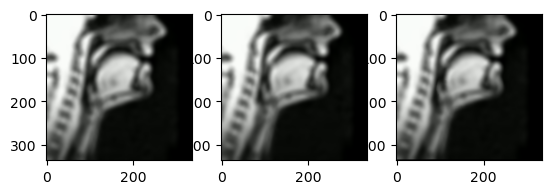

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Structural similarity between the 2 images: 0.9780490358856828


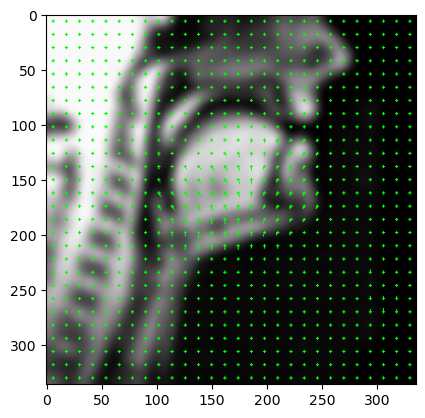

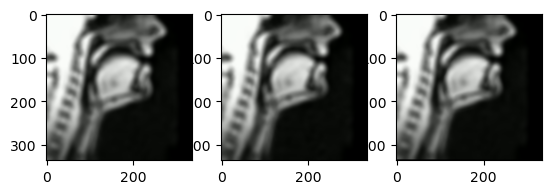

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Structural similarity between the 2 images: 0.9801985040034302


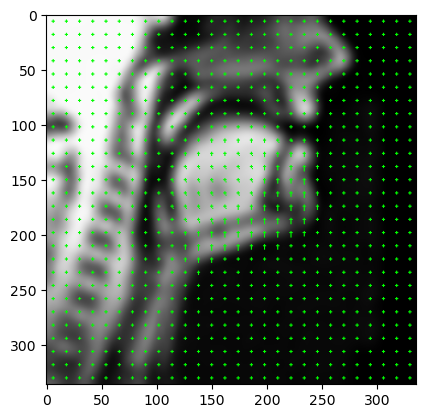

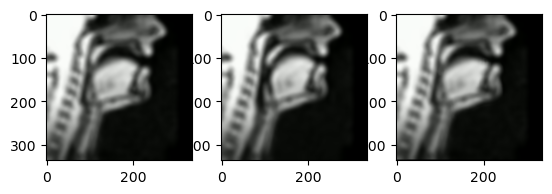

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Structural similarity between the 2 images: 0.9445812855935686


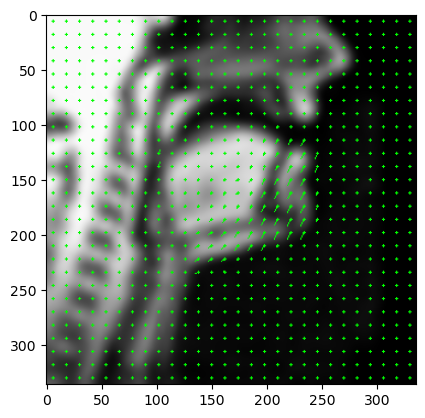

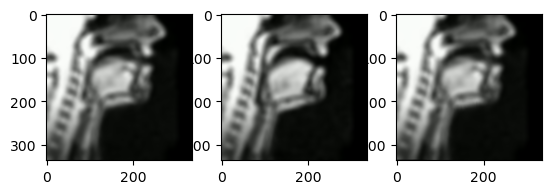

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Structural similarity between the 2 images: 0.899868633464589


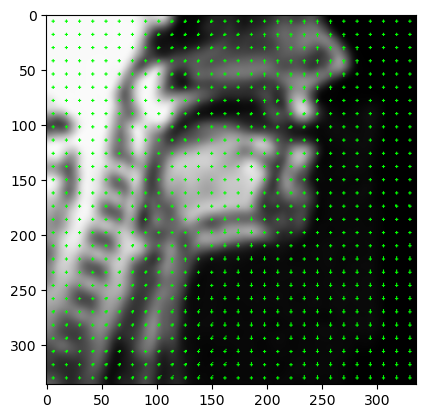

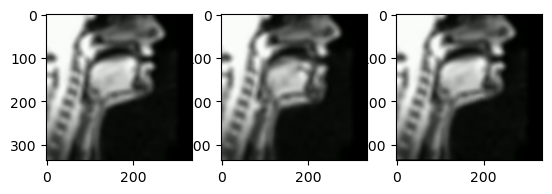

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Structural similarity between the 2 images: 0.9138835043617146


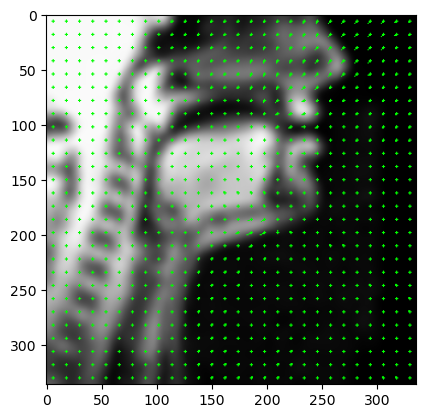

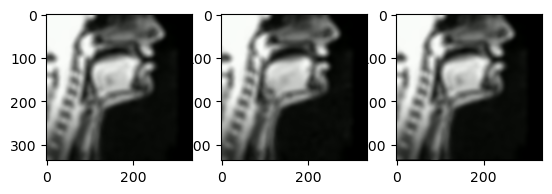

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Structural similarity between the 2 images: 0.9588514544888516


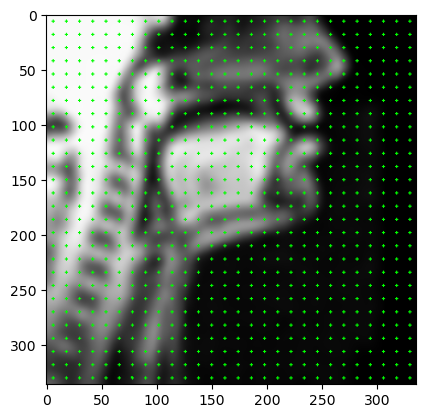

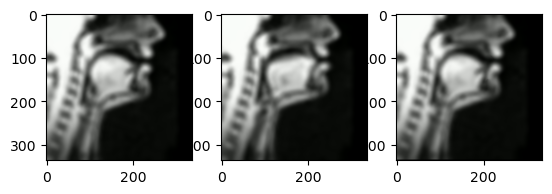

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Structural similarity between the 2 images: 0.9227195543507515


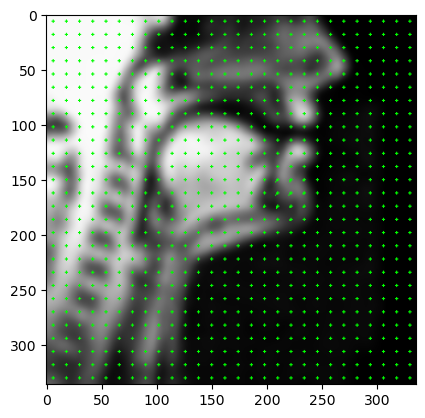

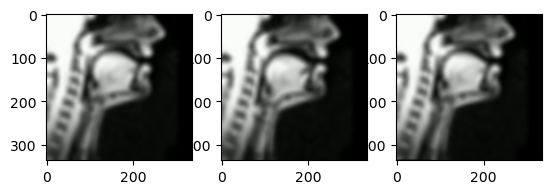

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Structural similarity between the 2 images: 0.9326893273634798


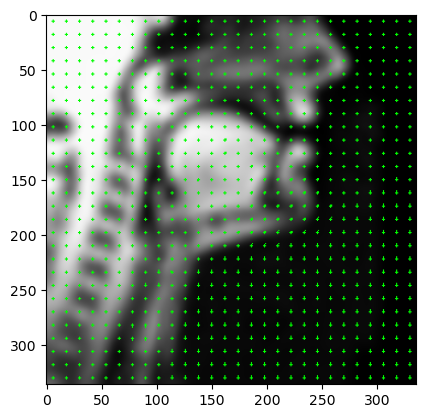

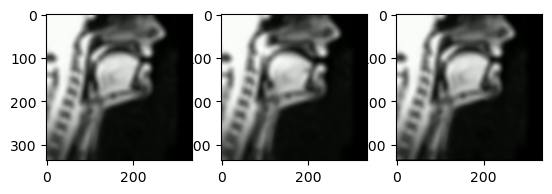

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Structural similarity between the 2 images: 0.9368489396779512


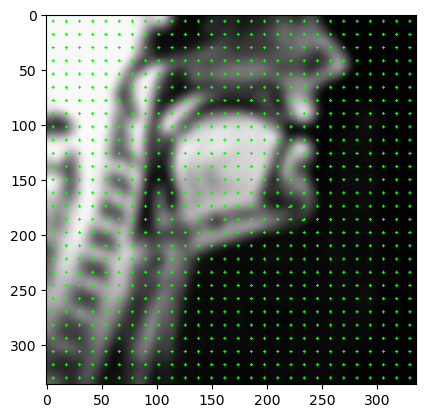

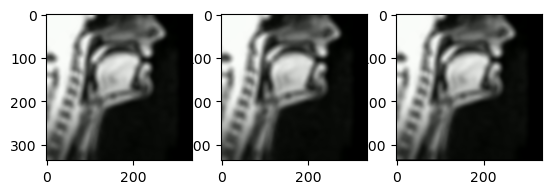

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Structural similarity between the 2 images: 0.9808171616610302


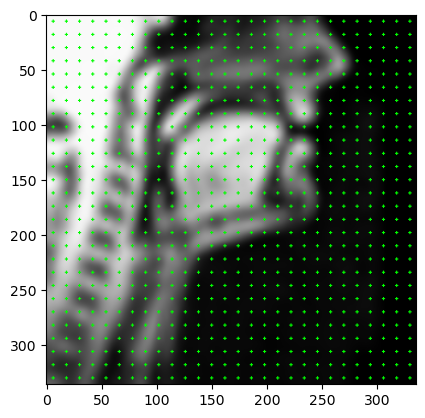

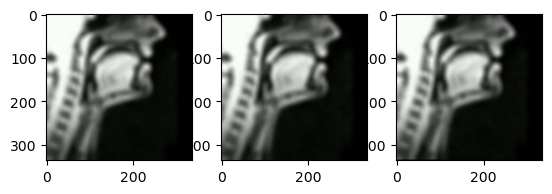

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Structural similarity between the 2 images: 0.984222832756949


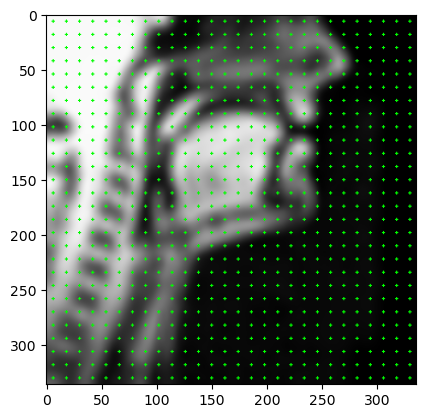

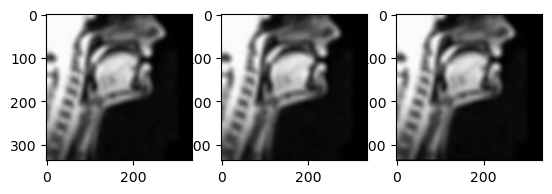

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Structural similarity between the 2 images: 0.9828610274570168


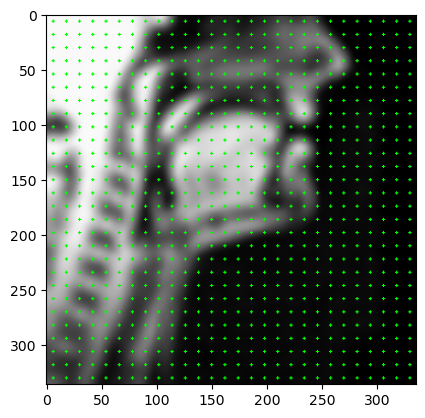

0.9512992717554178


In [150]:
# from raft_functions import evaluate_raft
evaluation = evaluate_raft_2(img1__batch, img2__batch, predicted_flow1, 'backward')
print(evaluation)

In [ ]:
from torchvision.io import read_video_timestamps
stamps = read_video_timestamps(str(path), 'sec')

In [ ]:
img1_batch.shape

The RAFT model accepts RGB images. We first get the frames from
:func:`~torchvision.io.read_video` and resize them to ensure their dimensions
are divisible by 8. Note that we explicitly use ``antialias=False``, because
this is how those models were trained. Then we use the transforms bundled into
the weights in order to preprocess the input and rescale its values to the
required ``[-1, 1]`` interval.



In [ ]:
from torchvision.models.optical_flow import Raft_Large_Weights

weights = Raft_Large_Weights.DEFAULT
transforms = weights.transforms()


def preprocess(img1_batch, img2_batch):
    # img1_batch = F.resize(img1_batch, size=[520, 960], antialias=False)
    # img2_batch = F.resize(img2_batch, size=[520, 960], antialias=False)
    img1_batch = F.resize(img1_batch, size=[248, 248], antialias=False) # resize frames to ensure they are divisable by 8 
    img2_batch = F.resize(img2_batch, size=[248, 248], antialias=False)
    return transforms(img1_batch, img2_batch)


img1__batch, img2__batch = preprocess(img1_batch, img2_batch)

print(f"shape = {img1__batch.shape}, dtype = {img1__batch.dtype}")

In [ ]:

print(f"shape = {img1__batch.shape}, dtype = {img1__batch.dtype}")

In [ ]:
plot(img1__batch[0])

In [ ]:
print(f"shape = {img1_batch.shape}, dtype = {img1_batch.dtype}")

## Estimating Optical flow using RAFT
We will use our RAFT implementation from
:func:`~torchvision.models.optical_flow.raft_large`, which follows the same
architecture as the one described in the [original paper](https://arxiv.org/abs/2003.12039).
We also provide the :func:`~torchvision.models.optical_flow.raft_small` model
builder, which is smaller and faster to run, sacrificing a bit of accuracy.



In [ ]:
from torchvision.models.optical_flow import raft_large

# If you can, run this example on a GPU, it will be a lot faster.
device =  "cpu"

model = raft_large(weights=Raft_Large_Weights.DEFAULT, progress=False).to(device)
model = model.eval()

list_of_flows = model(img1__batch.to(device), img2__batch.to(device))
print(f"type = {type(list_of_flows)}")
print(f"length = {len(list_of_flows)} = number of iterations of the model")

In [ ]:
device

The RAFT model outputs lists of predicted flows where each entry is a
(N, 2, H, W) batch of predicted flows that corresponds to a given "iteration"
in the model. For more details on the iterative nature of the model, please
refer to the [original paper](https://arxiv.org/abs/2003.12039). Here, we
are only interested in the final predicted flows (they are the most acccurate
ones), so we will just retrieve the last item in the list.

As described above, a flow is a tensor with dimensions (2, H, W) (or (N, 2, H,
W) for batches of flows) where each entry corresponds to the horizontal and
vertical displacement of each pixel from the first image to the second image.
Note that the predicted flows are in "pixel" unit, they are not normalized
w.r.t. the dimensions of the images.



In [ ]:
predicted_flows = list_of_flows[-1]
print(f"dtype = {predicted_flows.dtype}")
print(f"shape = {predicted_flows.shape} = (N, 2, H, W)")
print(f"min = {predicted_flows.min()}, max = {predicted_flows.max()}")

## Visualizing predicted flows
Torchvision provides the :func:`~torchvision.utils.flow_to_image` utlity to
convert a flow into an RGB image. It also supports batches of flows.
each "direction" in the flow will be mapped to a given RGB color. In the
images below, pixels with similar colors are assumed by the model to be moving
in similar directions. The model is properly able to predict the movement of
the ball and the player. Note in particular the different predicted direction
of the ball in the first image (going to the left) and in the second image
(going up).



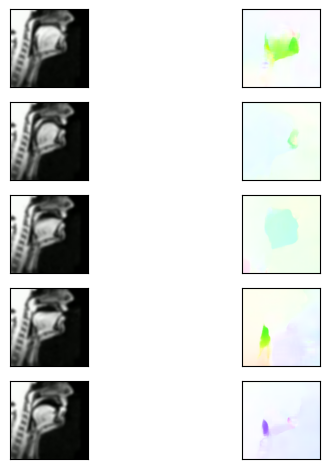

In [26]:
from torchvision.utils import flow_to_image

flow_imgs = flow_to_image(predicted_flow1)

# The images have been mapped into [-1, 1] but for plotting we want them in [0, 1]
img_batch = [(img1 + 1) / 2 for img1 in img1__batch[0:5]]

grid = [[img1, flow_img] for (img1, flow_img) in zip(img_batch[0:5], flow_imgs[0:5])]
plot(grid)

Converting torch predicted flows to numpy flows

In [ ]:
def convert_flow(predicted_flows):
    flows_tchw = [predicted_flows[a].detach().numpy()[:,:,:] for a in range(predicted_flows.shape[0])] # make it back to numpy arrays for all N predicted flows
    flows = np.moveaxis(flows_tchw, 1, -1) # change the dimmensions from TCHW to THWC
    return flows

# flow1 =predicted_flows
# print(predicted_flows.shape)
# flow1 = flow1.detach().numpy()[:, :,:,:]
# flows = np.moveaxis(flow1, 0, -1)
flows = convert_flow(predicted_flow1)
print(flows.shape) # N H T 2

Converting torch image to numpy image

In [ ]:
def convert_images(img_batch):
    # print(img_batch.shape)
    # img2_batch = [(img2 + 1) / 2 for img2 in img_batch] # upsampling the image back to original
    # print(len(img2_batch))
    img2 = np.array([np.moveaxis(img2_batch[a].numpy()[:,:,:], 0, -1) for a in range(len(img2_batch))])
    return img2

images1 = convert_images(img1_batch) # all frames 1
images2 = convert_images(img2_batch) # all frames 2
# print(convert_torch(img1_batch))
print(images1.shape)
plt.imshow(images1[0])

Drawing optical flow on top of the image

In [ ]:
import cv2
def draw_flow(img, flow, step=16):
        h, w = img.shape[:2]
        y, x = np.mgrid[step/2:h:step, step/2:w:step].reshape(2,-1).astype(int)
        fx, fy = flow[y,x].T
        lines = np.vstack([x, y, x+fx, y+fy]).T.reshape(-1, 2, 2)
        lines = np.int32(lines + 0.5)
        vis = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
        cv2.polylines(vis, lines, 0, (0, 255, 0))
        for (x1, y1), (_x2, _y2) in lines:
            cv2.circle(vis, (x1, y1), 1, (0, 255, 0), -1)
        return vis

In [ ]:
for i in range(10):
    plt.imshow(images1[i])
    plt.show()

In [ ]:
print(images1.shape)
flows.shape

In [ ]:
plt.imshow(draw_flow(images1[1, :, :, 0], flows[1,  : , : , :]))

In [ ]:
x = np.linspace(0, images1[1].shape[0], images1[1].shape[0])
y = np.linspace(0, images1[1].shape[1], images1[1].shape[1])
xv, yv = np.meshgrid(x,y)
map_x = -flows[1, :, :, 0] + xv
map_y = -flows[1, :, :, 1] + yv

map_x = map_x.astype(np.float32)

map_y.astype(np.float32)
type(map_x.astype(np.float32))

mapped_img = cv2.remap(images1[1], map_x.astype(np.float32), map_y.astype(np.float32), cv2.INTER_LINEAR) #pull back mapping to avoid holes in the image
plt.imshow(images1[1], cmap = 'gray'), plt.show()
plt.imshow(mapped_img, cmap = "gray")
plt.show()
# print(mapped_img)

from skimage import metrics as sm

print('First image warped into the second:', sm.structural_similarity(images2[1, :, :, 0], mapped_img[:,:,0]))

In [ ]:
remapping = 'forward'
print(remapping)

In [ ]:
def remap_forward(image, flow):
    flow[np.isnan(flow)] = 0
    x = np.linspace(0, image.shape[0], image.shape[0])
    y = np.linspace(0, image.shape[1], image.shape[1])
    xv, yv = np.meshgrid(x,y)
    map_x = -flow[:, :, 0] + xv
    map_y = -flow[:, :, 1] + yv

    mapped_img = cv2.remap(image, map_x.astype(np.float32), map_y.astype(np.float32), cv2.INTER_LINEAR) #pull back mapping to avoid holes in the image
    return mapped_img

In [ ]:
def remap_backward(image, flow):
    flow[np.isnan(flow)] = 0
    x = np.linspace(0, image.shape[0], image.shape[0])
    y = np.linspace(0, image.shape[1], image.shape[1])
    xv, yv = np.meshgrid(x,y)
    map_x = flow[:, :, 0] + xv
    map_y = flow[:, :, 1] + yv

    mapped_img = cv2.remap(image, map_x.astype(np.float32), map_y.astype(np.float32), cv2.INTER_LINEAR) #pull back mapping to avoid holes in the image
    return mapped_img

In [ ]:
def draw_process_evaluate(image1, image2, mapped):
    plt.subplot(1,3,1)
    plt.imshow(image1)
    plt.subplot(1,3,2)
    plt.imshow(image2)
    plt.subplot(1,3,3)
    plt.imshow(mapped, cmap = "gray")
    plt.show()
    print('Structural similarity between the 2 images:', sm.structural_similarity(image2[:, :, 0], mapped[:,:,0]))

In [ ]:
def draw_remap_with_flow(image, image2, flow):
    flow[np.isnan(flow)] = 0
    x = np.linspace(0, image.shape[0], image.shape[0])
    y = np.linspace(0, image.shape[1], image.shape[1])
    xv, yv = np.meshgrid(x,y)
    map_x = flow[:, :, 0] + xv
    map_y = flow[:, :, 1] + yv

    mapped_img = cv2.remap(image, map_x.astype(np.float32), map_y.astype(np.float32), cv2.INTER_LINEAR) #pull back mapping to avoid holes in the image
    
    plt.subplot(1,3,1)
    plt.imshow(image)
    plt.subplot(1,3,2)
    plt.imshow(image2)
    plt.subplot(1,3,3)
    plt.imshow(mapped_img, cmap = "gray")
    plt.show()

    from skimage import metrics as sm

    print('Second image warped into the first:', sm.structural_similarity(image2[:, :, 0], mapped_img[:,:,0]))


In [ ]:
mapped = remap_forward(images1[1], flows[1])
print('First image warped into the second:', sm.structural_similarity(images2[1, :, :, 0], mapped[:,:,0]))
draw_process_evaluate(images1[1], images2[1], mapped)

In [ ]:
mapped = remap_backward(images2[1], flows[1])
print('First image warped into the second:', sm.structural_similarity(images1[1, :, :, 0], mapped[:,:,0]))
draw_process_evaluate(images2[1], images1[1], mapped)


In [ ]:
draw_remap_with_flow(images2[1], images1[1], flows[1])

In [ ]:
import flowpy
predicted_flows[np.isnan(predicted_flows)] = 0
warped_second_image = flowpy.forward_warp(img1_batch, predicted_flows)

fig, ax = plt.subplots()

ax.imshow(warped_second_image, cmap = 'gray')
ax.set_title( "First image warped to the second")
ax.set_axis_off()

In [ ]:
import flowpy

flows[1][np.isnan(flows[1])] = 0
warped_first_image = flowpy.backward_warp(images2[1], flows[1])

fig, axes = plt.subplots(3, 1)
# fig, ax = plt.subplots(2, 2, figsize=(10,7))
for ax, image, title in zip(axes, (images1[1, :,:,0], images2[1, :,:,0], warped_first_image[:,:, 0]),
                            ("First Image", "Second Image", "Second image warped to first image")):
    ax.imshow(image, cmap = 'gray')
    ax.set_title(title)
    ax.set_axis_off()

plt.show()
print('Second image warped into the first:', sm.structural_similarity(images1[1, :, :, 0], warped_first_image[:,:,0]))

In [ ]:
import flowpy

flows[1][np.isnan(flows[1])] = 0
warped_first_image = flowpy.forward_warp(images1[1], flows[1])

fig, axes = plt.subplots(3, 1)
# fig, ax = plt.subplots(2, 2, figsize=(10,7))
for ax, image, title in zip(axes, (images1[1, :,:,0], images2[1, :,:,0], warped_first_image[:,:, 0]),
                            ("First Image", "Second Image", "Second image warped to first image")):
    ax.imshow(image, cmap = 'gray')
    ax.set_title(title)
    ax.set_axis_off()

plt.show()
print('First image warped into the second:', sm.structural_similarity(images2[1, :, :, 0], warped_first_image[:,:,0]))

## Bonus: Creating GIFs of predicted flows
In the example above we have only shown the predicted flows of 2 pairs of
frames. A fun way to apply the Optical Flow models is to run the model on an
entire video, and create a new video from all the predicted flows. Below is a
snippet that can get you started with this. We comment out the code, because
this example is being rendered on a machine without a GPU, and it would take
too long to run it.



In [ ]:
device = 'cpu'
print(device)

In [ ]:
from torchvision.io import write_jpeg
for i, (img1, img2) in enumerate(zip(frames[40:80], frames[41:81])):
    # Note: it would be faster to predict batches of flows instead of individual flows
    img1_batch = torch.stack([img1[ :, 100:600, 500:1000], img1[:, 100:600, 500:1000]])
    img2_batch = torch.stack([img2[ :, 100:600, 500:1000], img2[:, 100:600, 500:1000]])
    img1, img2 = preprocess(img1_batch, img2_batch)

    list_of_flows = model(img1.to(device), img2.to(device))
    predicted_flow = list_of_flows[-1][0]
    flow_img = flow_to_image(predicted_flow).to("cpu")
    output_folder = "C:/Users/Misha/OneDrive - University of Sussex/FYP"  # Update this to the folder of your choice
    write_jpeg(flow_img, output_folder + f"predicted_flow_{i}.jpg")